# iq-dota-use-case

Object detection performance degradation with image compression.

In [149]:
import os
import mlflow

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from iquaflow.datasets import DSWrapper
from iquaflow.experiments import ExperimentSetup, ExperimentInfo, ExperimentVisual
from iquaflow.experiments.task_execution import PythonScriptTaskExecution

from custom_iqf import (
    DSModifierResize,
    DSModifier_jpg,
    DSModifier_quant
    )

In [ ]:
jpgmod = [DSModifier_jpg(params={"quality": quality}) for quality in range(10,100,10)]
quantmod = [DSModifier_quant(params={"bits": bits}) for bits in range(1,9)]
resizemod = [DSModifierResize(params={"scaleperc": perc}) for perc in range(10,100,10)]

combo_mod_lst = []
for quality in range(20,90,20):
    for bits in range(2,10,2):
        for perc in range(20,100,20):
            combo_mod_lst.append( 
                DSModifier_jpg(
                    ds_modifier=DSModifier_quant(
                        ds_modifier=DSModifierResize(
                            params={"scaleperc": perc}
                            ),
                        params={"bits": bits}
                        ),
                    params={"quality": quality}
                    )
                )

In [ ]:
for model,cropsz in zip([
    '/iqf/dota_rfcn_output_2000000_136610/frozen_inference_graph.pb',
    # '/iqf/dota608_ssd608_output_1243788/frozen_inference_graph.pb'
],[
    1024,
    # 608
]):

    #Experiment definition, pass as arguments all the components defined beforehand
    experiment = ExperimentSetup(
        experiment_name         = "iq-dota-use-case",
        task_instance           = PythonScriptTaskExecution( model_script_path = './inference.py' ),
        ref_dsw_train           = DSWrapper(data_path=f'/Nas/DOTA1_0/split_ss_dota1_0_glasgow_{cropsz}/val'),
        ds_modifiers_list       = [
            DSModifier_jpg(params={"quality": quality}) for quality in range(90,101,2)
        ] + [
            DSModifier_jpg(params={"quality": quality}) for quality in range(10,100,10)
        ] + [
            # DSModifier_quant(params={"bits": bits}) for bits in range(1,9)
        ] + [
            # DSModifierResize(params={"scaleperc": perc}) for perc in range(10,110,10)
        ] + [
            # *combo_mod_lst
        ],
        repetitions             = 1,
        cloud_options           = {
            'tracking_uri':'https://mlflow.ml.analytics-dev.satellogic.team/'
        },
        extra_train_params      = {
            'model':[model],
            'cu':['0,1,2']
            }
    )

    #Execute the experiment
    experiment.execute()

# Visualize

In [374]:
mlflow.set_tracking_uri('https://mlflow.ml.analytics-dev.satellogic.team/')

experiment_info = ExperimentInfo("iq-dota-use-case")

df = experiment_info.get_df(
    ds_params=["modifier",'CROPSZ','quality','outformat','bits','scaleperc'],
    metrics=['ap_0.5_all','Mb'],
    fields_to_float_lst = ['ap_0.5_all','Mb'],
    dropna=False
)

df = df[(df['ds_outformat'].notnull())]

df['compression'] = df['ds_quality']
for mod in ['ds_quality','ds_bits','ds_scaleperc']:
    df['compression'][df[mod].notnull()] = mod.replace('ds_','')
    
met1, met2 = 'Mb', 'ap_0.5_all'

In [376]:
df[(df['ds_outformat']=='png')]

,name,ds_modifier,ds_CROPSZ,ds_quality,ds_outformat,ds_bits,ds_scaleperc,ap_0.5_all,Mb,compression
0,val,None,1024,101,png,9,101,0.354898,1.297575,scaleperc
1,val_0,None,1024,101,png,9,101,0.354898,1.297575,scaleperc


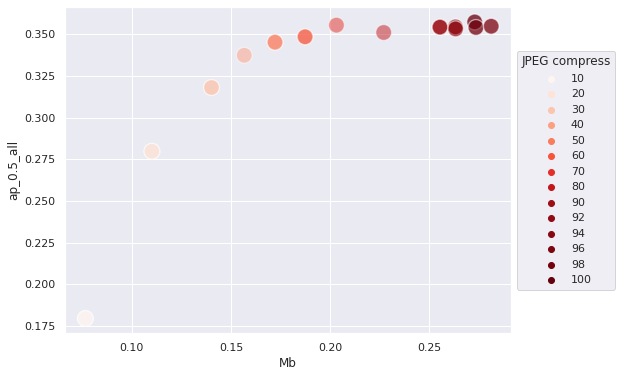

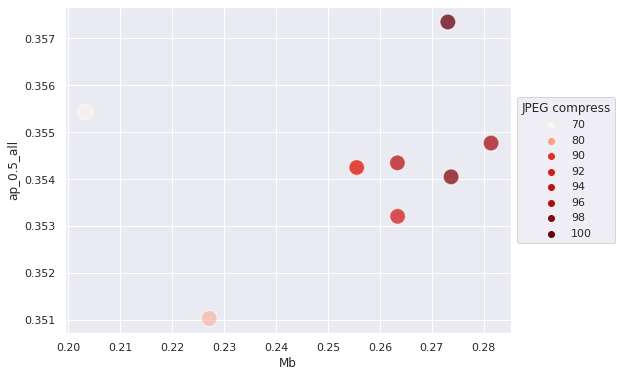

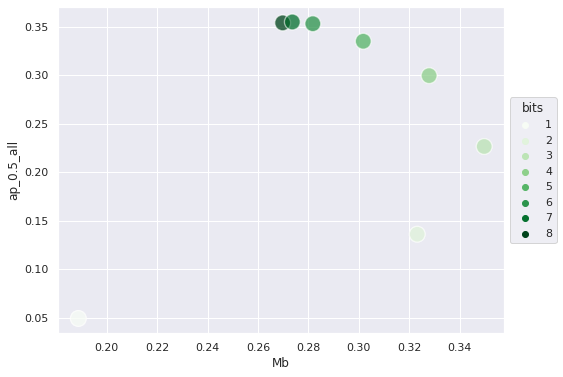

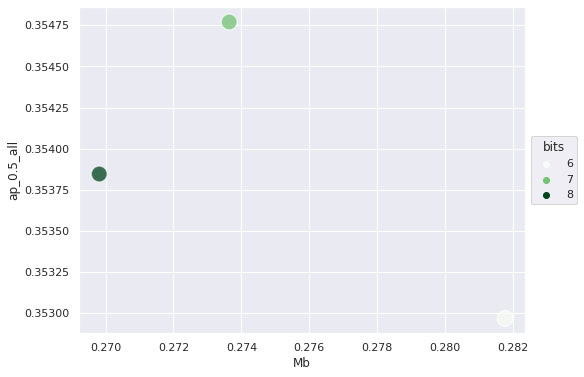

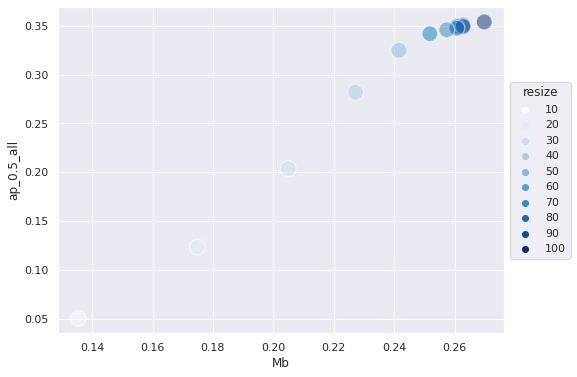

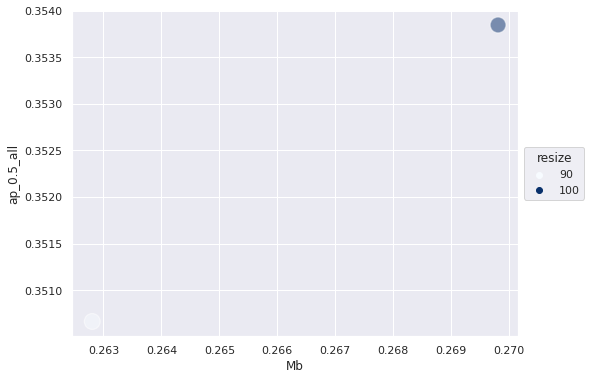

In [377]:
sns.set(style="darkgrid", rc={'figure.figsize':(8,6)})

for title,mod,pal in zip(
    ['JPEG compress','bits','resize'],
    ['ds_quality','ds_bits','ds_scaleperc'],
    ['Reds','Greens','Blues']
    
):
    
    for dfq in [
        df[(df[mod].notnull()) & (df['ds_outformat']=='jpg')],
        df[(df[mod].notnull()) & (df['ds_outformat']=='jpg') & (df['Mb']>0.16) & (df['ap_0.5_all']>0.35) ]
    ]:
        
        dfq[mod] = dfq[mod].astype(int)

        handle = sns.scatterplot(
            data=dfq, x=met1, y=met2,
            hue=mod,
            legend='full',
            palette=pal,
#             style=mod,
            alpha=0.5,
    #         marker='X',
            s=250
        )

        leg =  handle.legend(title=title, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

        plt.show()

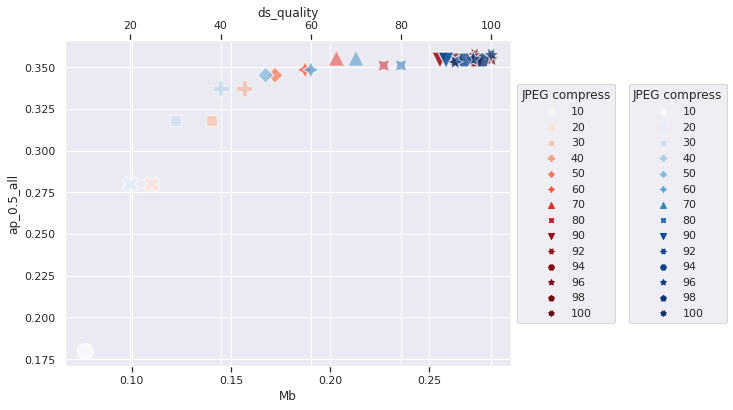

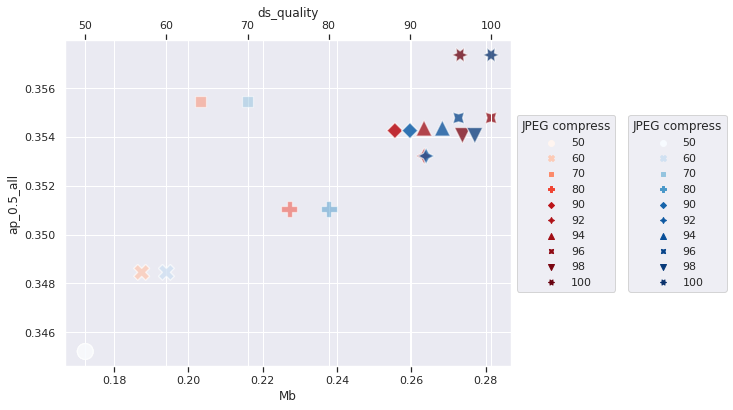

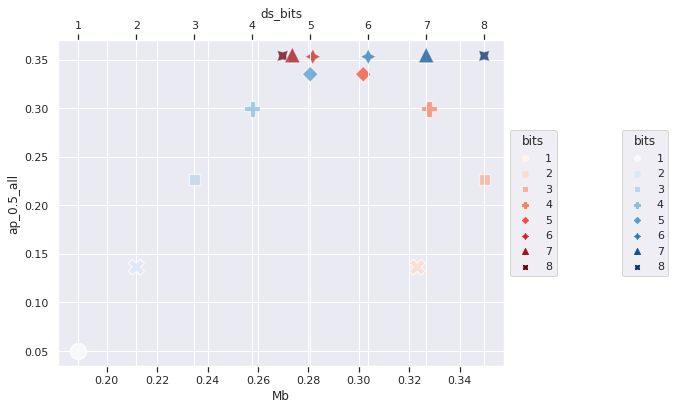

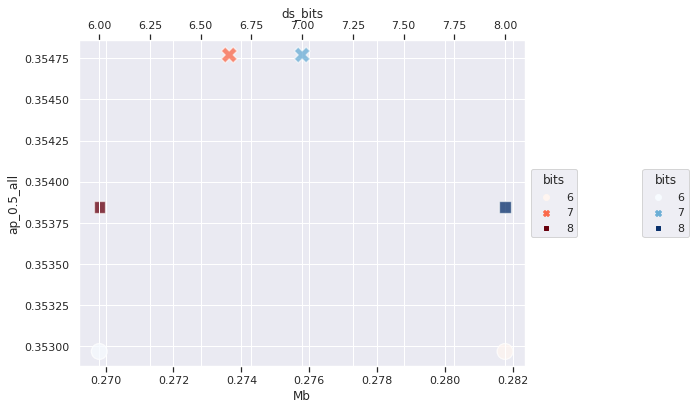

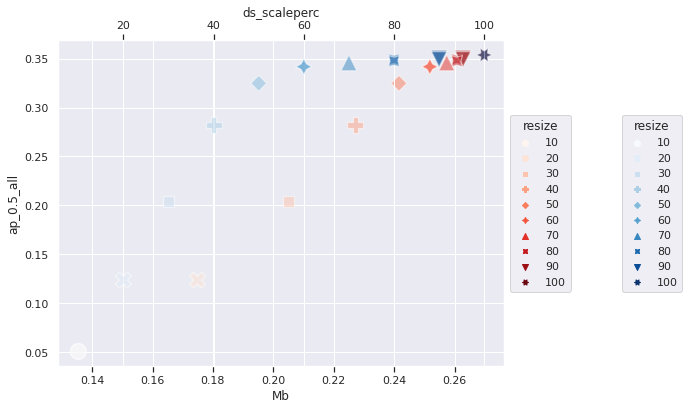

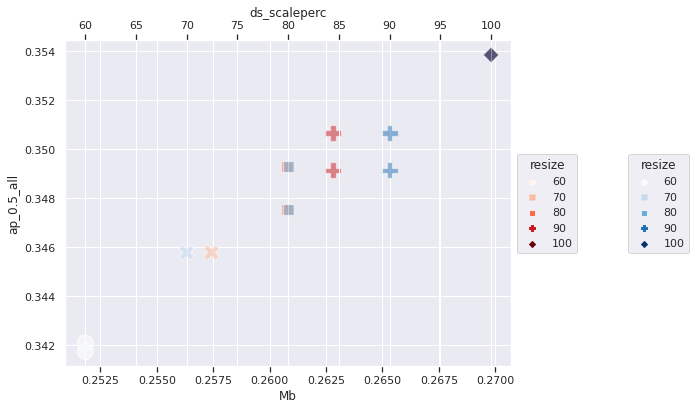

In [381]:
sns.set(style="darkgrid", rc={'figure.figsize':(8,6)})

for title,mod in zip(
    ['JPEG compress','bits','resize'],
    ['ds_quality','ds_bits','ds_scaleperc'],
    
):
    
    for dfq in [
        df[ (df[mod].notnull()) & (df['ds_outformat']=='jpg')],
        df[ (df[mod].notnull()) & (df['ds_outformat']=='jpg') & (df['Mb']>0.16) & (df['ap_0.5_all']>0.34) ]
    ]:
        
        dfq[mod] = dfq[mod].astype(int)

        handle = sns.scatterplot(
            data=dfq, x=met1, y=met2,
            hue=mod,
            legend='full',
            palette='Reds',
            style=mod,
            alpha=0.5,
    #         marker='X',
            s=250
        )

        leg =  handle.legend(title=title, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

        handle.twiny()

        handle2 = sns.scatterplot(
            data=dfq, x=mod, y=met2,
            hue=mod,
            legend='full',
            palette='Blues',
            style=mod,
            alpha=0.5,
    #         marker='o',
            s=250
        )

        leg2 =  handle2.legend(title=title, loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

        plt.show()

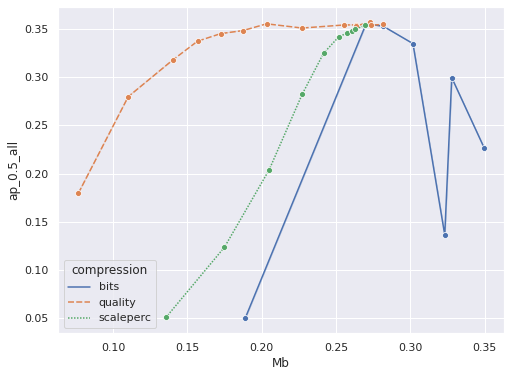

In [383]:
dfj = df[(df['ds_outformat']=='jpg')]

handle = sns.lineplot(
    data=dfj, x=met1, y=met2,
    hue=dfj['compression'],
    marker='o',
    style=dfj['compression']
)

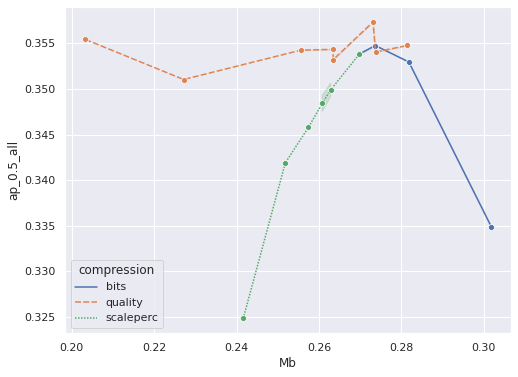

In [384]:
df2 = df[(df['ds_outformat']=='jpg') & (df['Mb']>0.2) & (df['ap_0.5_all']>0.3) ]

handle = sns.lineplot(
    data=df2, x=met1, y=met2,
    hue=df2['compression'],
    marker='o',
    style=df2['compression']
)